In [1]:
import pandas
import matplotlib
import seaborn
import collections

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('colorblind')
seaborn.set_style('whitegrid')

In [2]:
import sys
sys.path.append('..')

from helpers import ECOSYSTEMS, DATE_RANGE, load_data, create_snapshot, load_graph, RE_SEMVER

In [3]:
FIG_SIZE = (8, 4)
FIG_DATE_RANGE = (pandas.to_datetime('2007-01-01'), DATE_RANGE[-1])

In [31]:
df_data = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    packages, dependencies = load_data(ecosystem)
    df_data[ecosystem] = {
        'packages': packages, 
        'dependencies': dependencies,
    }

## Characteristics

In [5]:
df = pandas.DataFrame(index=ECOSYSTEMS)

for ecosystem, data in df_data.items():
    # Number of packages, versions and dependencies
    df.loc[ecosystem, 'packages'] = len(data['packages'].groupby('package'))
    df.loc[ecosystem, 'releases'] = len(data['packages'])
    df.loc[ecosystem, 'dependencies'] = len(data['dependencies'])
    
    # Oldest package
    df.loc[ecosystem, 'from_date'] = data['packages']['time'].min()
    df.loc[ecosystem, 'to_date'] = data['packages']['time'].max()
    
    # Latest snapshot
    sn_packages, sn_dependencies = create_snapshot(data['packages'], data['dependencies'], df.loc[ecosystem, 'to_date'])
    df.loc[ecosystem, 'sn_packages'] = len(sn_packages.groupby('package'))
    df.loc[ecosystem, 'sn_dependencies'] = len(sn_dependencies)
    
df.T

,cran,npm,rubygems
packages,9568,317159,122791
releases,57530,1.92775e+06,685591
dependencies,128113,7.6443e+06,1.67482e+06
from_date,1997-10-08 19:56:17,2010-11-09 23:36:08,2009-07-25 17:46:22
to_date,2016-04-26 20:52:26,2016-06-28 14:35:28.717000,2016-09-07 14:02:43.409000
sn_packages,9568,317159,122791
sn_dependencies,22191,728448,183127


## Packages, releases and dependencies over time

 (732677.0, 736116.0),

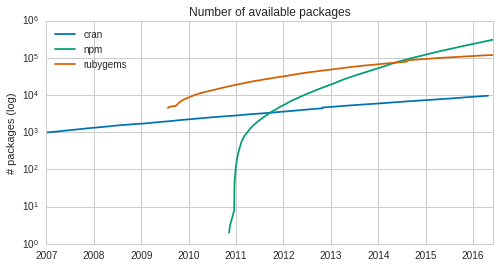

In [6]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby('package')
        [['time']]
        .min()
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of available packages',
    xlim=FIG_DATE_RANGE,
)

 (732677.0, 736116.0),

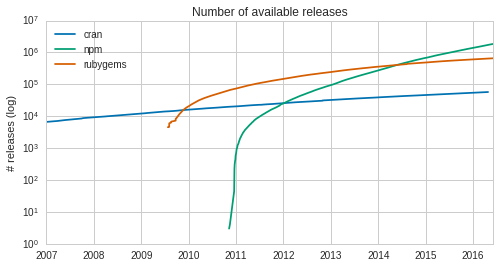

In [7]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='Number of available releases',
    xlim=FIG_DATE_RANGE,
)

 (732677.0, 736116.0),

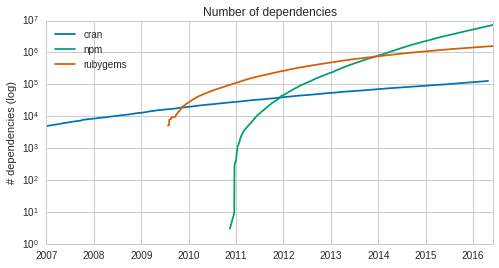

In [8]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .merge(data['dependencies'], how='right', on=['package', 'version'])
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True)

ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Number of dependencies',
    xlim=FIG_DATE_RANGE,
)

## New packages, releases and dependencies by month

 (444, 557),

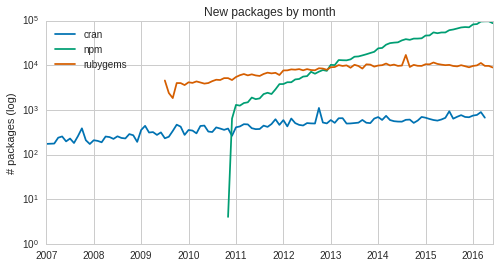

In [9]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby(['package', 'version'])
        [['time']]
        .min()
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='New packages by month',
    xlim=FIG_DATE_RANGE,
)

 (444, 557),

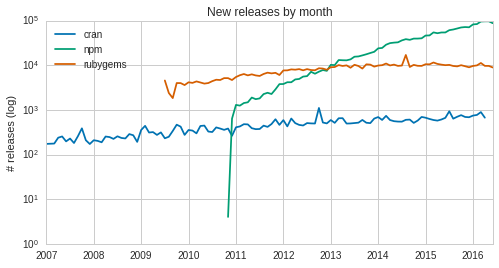

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='New releases by month',
    xlim=FIG_DATE_RANGE,
)

 (444, 557),

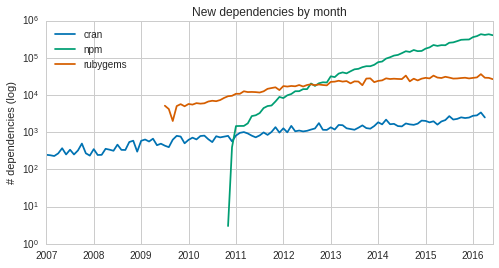

In [11]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .merge(data['dependencies'], how='right', on=['package', 'version'])
        [['time']]
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='New dependencies by month',
    xlim=FIG_DATE_RANGE,
)

## Delay before first update

In [12]:
# Time of first and next release
for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .sort_values(['package', 'time'])
        .set_index(['package', 'version'])
        .assign(next_release=lambda d: d['time'].shift(-1))
    )
    index_of_last_releases = (
        df
        .groupby(level='package', sort=False)
        .tail(1)
        .index
    )
    df.loc[index_of_last_releases, 'next_release'] = pandas.NaT
    df = df.reset_index()
    
    df_data[ecosystem]['packages'] = (
        df
        .groupby('package')
         [['time']]
         .min()
         .assign(first_release=lambda d: d['time'])
         [['first_release']]
         .reset_index()
         .merge(df, how='left', on='package')
    )

[(0, 1),
 (0, 18),

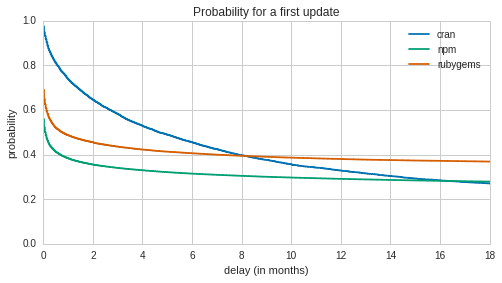

In [13]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

colors = iter(seaborn.color_palette())

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    color = next(colors)
    
    kmp_df = (
        data['packages']
        [data['packages']['time'] == data['packages']['first_release']]
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['first_release'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=color, ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Probability for a first update',
    xlim=(0, 18),
    ylim=(0, 1)
)    

## Delay between successive updates

[(0, 1),
 (0, 18),

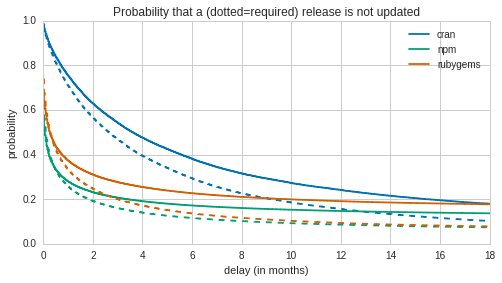

In [14]:
import lifelines
from lifelines.statistics import logrank_test

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

colors = iter(seaborn.color_palette())

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for ecosystem, data in df_data.items():
    color = next(colors)
    
    kmp_df = (
        data['packages']
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
        .assign(required=lambda d: d['package'].isin(data['dependencies']['dependency']))
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=color, ci_show=False)
    
    required = kmp_df['required'] == True
    kmp.fit(kmp_df[required]['duration'], kmp_df[required]['observed'])
    kmp.plot(ax=ax, color=color, style='--', legend=None, ci_show=False)
    
    tests[ecosystem] = logrank_test(
        kmp_df['duration'], kmp_df[required]['duration'],
        kmp_df['observed'], kmp_df[required]['observed'],
        alpha=0.99
    )
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Probability that a (dotted=required) release is not updated',
    xlim=(0, 18),
    ylim=(0, 1)
)    

In [15]:
for ecosystem, test in tests.items():
    print('{}: {}, significant: {}'.format(ecosystem, test.test_result, test.is_significant))

cran: Reject Null, significant: True
npm: Reject Null, significant: True
rubygems: Reject Null, significant: True


## Correlation between updates and dependencies

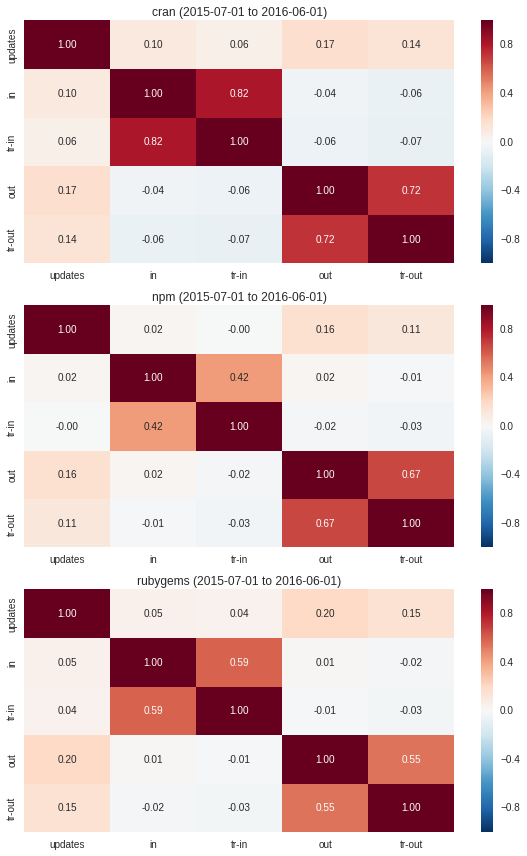

In [16]:
figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1]*len(ECOSYSTEMS)))

INTERVAL = [DATE_RANGE[-12], DATE_RANGE[-1]]

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    graph = load_graph(ecosystem, INTERVAL[0])
    mask = (INTERVAL[0] <= data['packages']['time']) & (data['packages']['time'] < INTERVAL[1])

    updates = (
        data['packages'][mask]
        [['package', 'version']]
        .groupby('package')
        .count()
        .reset_index()
        .rename(columns={'version': 'updates'})
    )

    for metric in ['in', 'tr-in', 'out', 'tr-out']:
        metric_df = pandas.DataFrame.from_records(
            zip(graph.vs['name'], graph.vs[metric]), 
            columns=['package', metric]
        )
        updates = updates.merge(metric_df, on='package')

    updates = updates.set_index('package').fillna(0)
    
    seaborn.heatmap(updates.corr(), annot=True, fmt='2.2f', ax=ax)
    ax.set(
        title='{} ({} to {})'.format(
            ecosystem, 
            INTERVAL[0].strftime('%Y-%m-%d'),
            INTERVAL[1].strftime('%Y-%m-%d')
        ),
    )
    
matplotlib.pyplot.tight_layout()    

## Packages with semver

In [32]:
# Extract semver
for ecosystem, data in df_data.items():
    data['packages'] = (
        pandas.concat([
            data['packages'], 
            data['packages']['version'].str.extract(RE_SEMVER, expand=True)
        ], axis=1, join='inner')
        .assign(semver=lambda d: ~(d[['v_major', 'v_minor', 'v_patch']].isnull().any(axis=1)))
    )

In [33]:
# Tag package "semver_all" if all its releases are semver compliant
for ecosystem, data in df_data.items():
    not_semver = (
        data['packages']
        .query('semver == False')
        ['package']
    )
    data['packages'] = (
        data['packages']
        .assign(semver_all=lambda d: ~d['package'].isin(not_semver))
    )

In [37]:
# Detect release type
for ecosystem, data in df_data.items():

    df = (
        data['packages']
        # Keep packages that are fully semver compliant
        .query('semver_all == True')

        .sort_values(['package', 'v_major', 'v_minor', 'v_patch', 'time'])

        # Shift to combine previous/current version
        .pipe(lambda d: 
            d.join(
                d[['package', 'v_major', 'v_minor', 'v_patch', 'time']].shift(1),
                rsuffix='_previous'
            )
        )
        .assign(release_type='unknown')
        .assign(release_delay=lambda d: d['time'] - d['time_previous'])
    )

    df.loc[df['v_patch'] != df['v_patch_previous'], 'release_type'] = 'patch'
    df.loc[df['v_minor'] != df['v_minor_previous'], 'release_type'] = 'minor'
    df.loc[df['v_major'] != df['v_major_previous'], 'release_type'] = 'major'
    df.loc[df['package'] != df['package_previous'], 'release_type'] = 'initial'
    df.loc[df['package'] != df['package_previous'], 'release_delay'] = pandas.NaT

    data['semver'] = df.drop(
        ['semver', 'semver_all', 'package_previous', 'v_patch_previous', 'v_minor_previous', 'v_major_previous', 'time_previous'],
        axis=1
    )

[(0, 1.01),
 (732677.0, 736116.0),

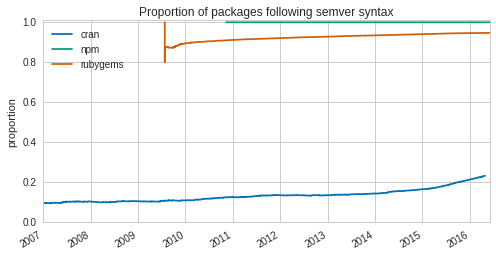

In [35]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .groupby('package')
        [['time', 'semver_all']]
        .min()
        .set_index('time')
        .sort_index()
        .assign(n=1, n_semver=lambda d: d['semver_all'].astype(int))
        [['n', 'n_semver']]
        .cumsum()
        .assign(**{ecosystem: lambda d: d['n_semver'] / d['n']})
    )
    
    df[[ecosystem]].plot(ax=ax)
    
ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Proportion of packages following semver syntax',
    xlim=FIG_DATE_RANGE,
    ylim=(0, 1.01),
)

## Type of updates for packages with semver

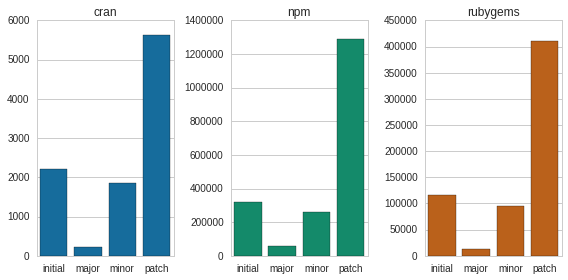

In [92]:
figure, axes = matplotlib.pyplot.subplots(ncols=len(ECOSYSTEMS))
figure.set_size_inches(FIG_SIZE)

# figure.suptitle('Type of release for packages following semver')

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    seaborn.countplot(
        x='release_type', 
        data=data['semver'],# .query('release_type != "initial"'),
        order=['initial', 'major', 'minor', 'patch'],
        color=seaborn.color_palette()[i],
        ax=ax
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='',
        # yscale='log',
    )

matplotlib.pyplot.tight_layout()

## Distribution of update types per package

## Delay between updates, by type

## Delay before first dependent

[(0, 1),
 (0, 36),

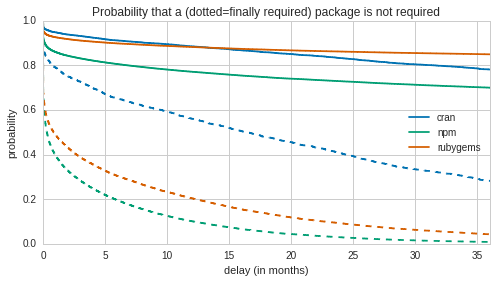

In [19]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

colors = iter(seaborn.color_palette())

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    color = next(colors)
    
    first_dependent = (
        data['packages']
        .merge(data['dependencies'], on=['package', 'version'])
        [['dependency', 'time']]
        .groupby('dependency')
        .min()
        .rename(columns={'time': 'dependent'})
    )

    kmp_df = (
        data['packages']
        .groupby('package')
        [['time']]
        .min()
        .join(first_dependent)
        .assign(observed=lambda d: ~d['dependent'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: (d['dependent'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30)
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=color, ci_show=False)
    
    required = kmp_df['observed'] == True
    kmp.fit(kmp_df[required]['duration'], kmp_df[required]['observed'])
    kmp.plot(ax=ax, color=color, style='--', legend=None, ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Probability that a (dotted=finally required) package is not required',
    xlim=(0, 36),
    ylim=(0, 1)
)    

## Delay between consecutive dependents

[(0, 1),
 (0, 18),

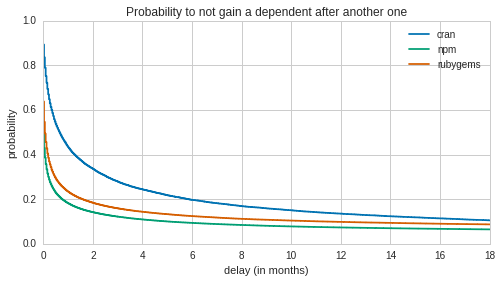

In [20]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

colors = iter(seaborn.color_palette())

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    color = next(colors)
    

    df = (data['dependencies']
     .merge(data['packages'], on=['package', 'version'])
     .groupby(['package', 'dependency'])
     [['time']]
     .min()
     .reset_index()
     [['dependency', 'time']]
     .sort_values(['dependency', 'time'])
     .set_index('dependency')
     .assign(next_dependent=lambda d: d['time'].shift(-1))
     .reset_index()
    )

    index_of_last_dependents = (
        df
        .groupby('dependency', sort=False)
        .tail(1)
        .index
    )

    df.loc[index_of_last_dependents, 'next_dependent'] = pandas.NaT
    
    kmp_df = (
        df
        .assign(observed=lambda d: ~d['next_dependent'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_dependent'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=color, ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Probability to not gain a dependent after another one',
    xlim=(0, 18),
    ylim=(0, 1)
)    